In [1]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dfs = []
for file in os.listdir('data'):
    if file.startswith('data'):
        df = pd.read_csv(f'data/{file}')
        dfs.append(df)

In [3]:
df = pd.concat(dfs, ignore_index=True)

In [4]:
df['Date']= pd.to_datetime(df['Date'])
df.drop_duplicates('Date', inplace=True)
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

In [5]:
df['Pct'] = ((df['Close'] - df['Open'])/df['Close'])*100

In [6]:
df

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Pct
Date,,,,,,,
2009-05-26,7072.70,7142.05,6813.10,6851.10,25573104,1732.34,-3.234517
2009-05-27,7013.80,7234.05,7013.80,7215.20,26964148,1928.57,2.791329
2009-05-28,7202.35,7376.05,7143.40,7338.60,42525652,2989.31,1.856621
2009-05-29,7373.90,7496.75,7362.90,7416.00,31676768,2083.5,0.567691
2009-06-01,7559.30,7559.30,7287.15,7364.05,31978183,2098.04,-2.651394
...,...,...,...,...,...,...,...
2022-07-04,33558.85,33978.50,33515.60,33940.90,-,-,1.125633
2022-07-05,34084.70,34361.05,33757.00,33815.90,115009518,3980.84,-0.794892
2022-07-06,33929.40,34388.50,33876.15,34324.25,122736123,4709.36,1.150353


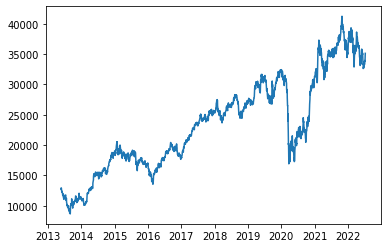

In [8]:
plt.plot(df[1000:].index, df[1000:]['Close'])
plt.show()

### Model

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler 

In [10]:
tf.__version__

'2.9.1'

In [11]:
values = df['Close'].values
training_data_len = math.ceil(len(values)* 0.8)
training_data_len

2607

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

In [13]:
x_train = []
y_train = []

WINDOW = 60
for i in range(WINDOW, len(train_data)):
    x_train.append(train_data[i-WINDOW:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
test_data = scaled_data[training_data_len-WINDOW: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(WINDOW, len(test_data)):
    x_test.append(test_data[i-WINDOW:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### LSTM

In [15]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size = 1, epochs = 50)

Epoch 1/50
2547/2547 [==============================] - 69s 25ms/step - loss: 7.7741e-04
Epoch 2/50
2547/2547 [==============================] - 64s 25ms/step - loss: 5.3549e-04
Epoch 3/50
2547/2547 [==============================] - 69s 27ms/step - loss: 3.3855e-04
Epoch 4/50
2547/2547 [==============================] - 72s 28ms/step - loss: 3.1811e-04
Epoch 5/50
2547/2547 [==============================] - 72s 28ms/step - loss: 2.6092e-04
Epoch 6/50
2547/2547 [==============================] - 72s 28ms/step - loss: 2.6667e-04
Epoch 7/50
2547/2547 [==============================] - 71s 28ms/step - loss: 2.5208e-04
Epoch 8/50
2547/2547 [==============================] - 71s 28ms/step - loss: 2.4092e-04
Epoch 9/50
2547/2547 [==============================] - 71s 28ms/step - loss: 2.1554e-04
Epoch 10/50
2547/2547 [==============================] - 71s 28ms/step - loss: 2.1855e-04
Epoch 11/50
2547/2547 [==============================] - 72s 28ms/step - loss: 1.7898e-04
Epoch 12/50
2547/25

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

21/21 [==============================] - 2s 33ms/step


1280.1359705021114

<ipython-input-18-349a6251f481>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


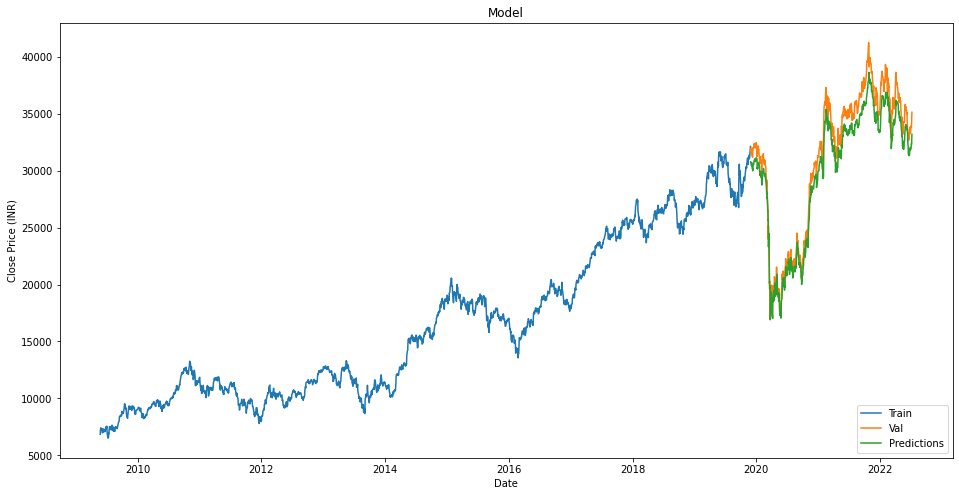

In [18]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
model.save('model/lstm_bnf_model_v4.h5', save_format='h5')

In [20]:
import pickle
pickle.dump(scaler, open('model/MinMaxScaler_v4.pkl', 'wb'))